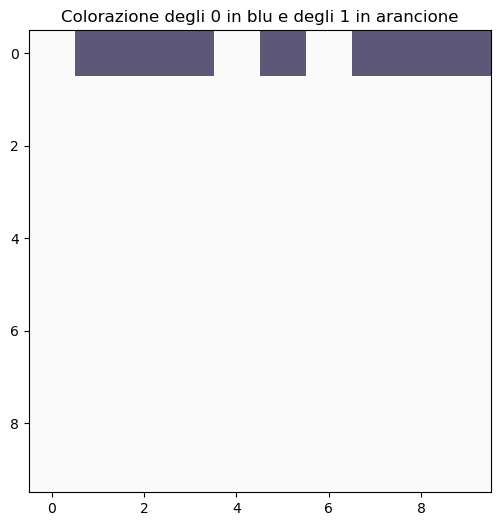

Etichette dei cluster: [0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


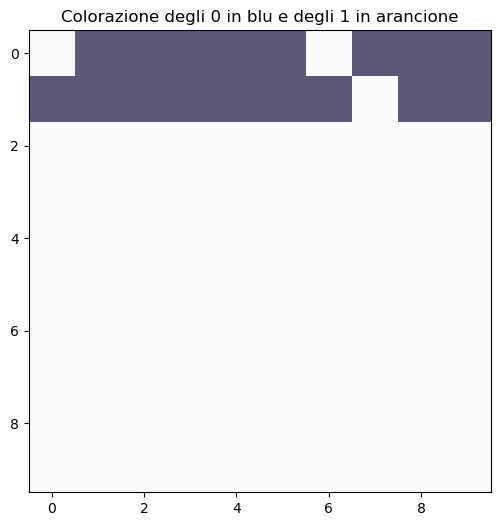

Etichette dei cluster: [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


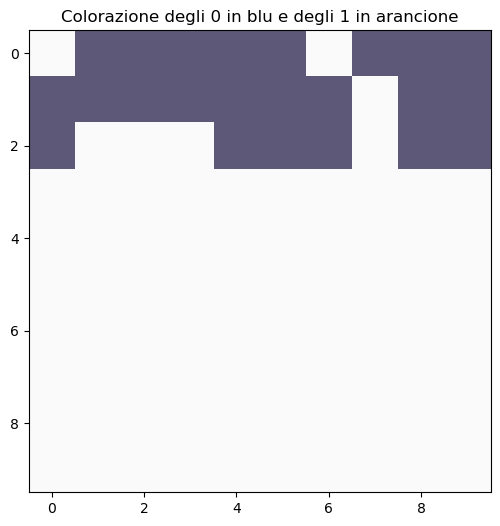

Etichette dei cluster: [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


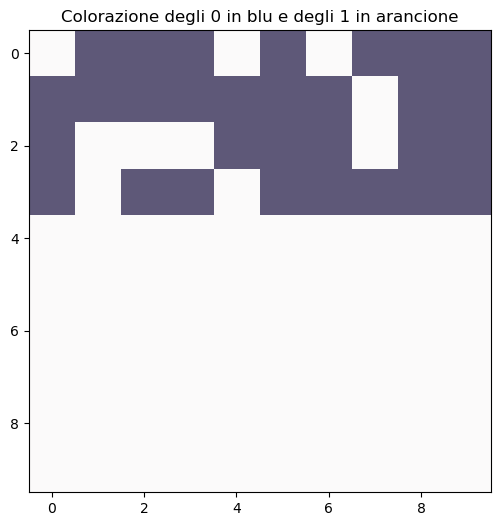

Etichette dei cluster: [0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


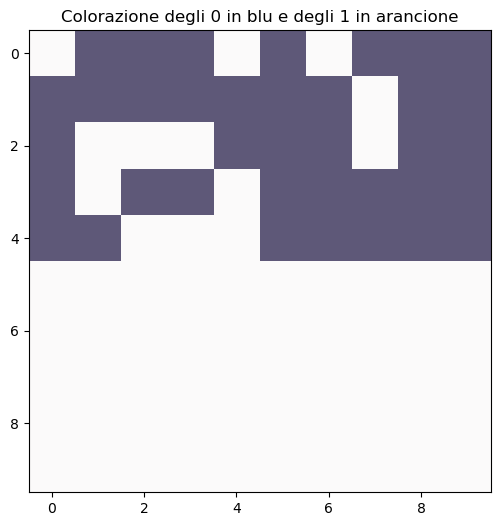

Etichette dei cluster: [0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


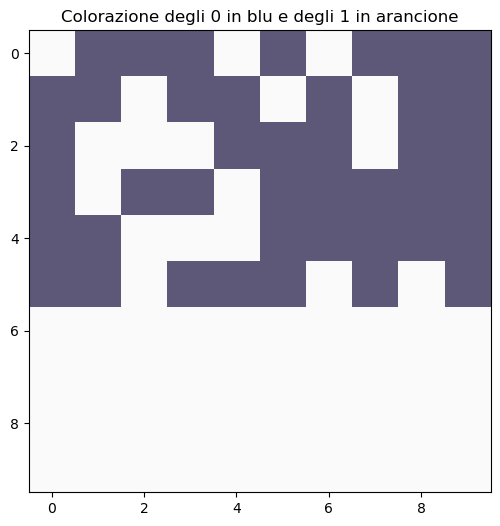

Etichette dei cluster: [0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


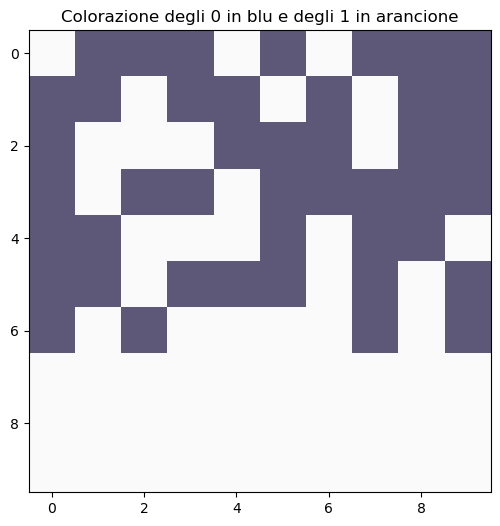

Etichette dei cluster: [0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


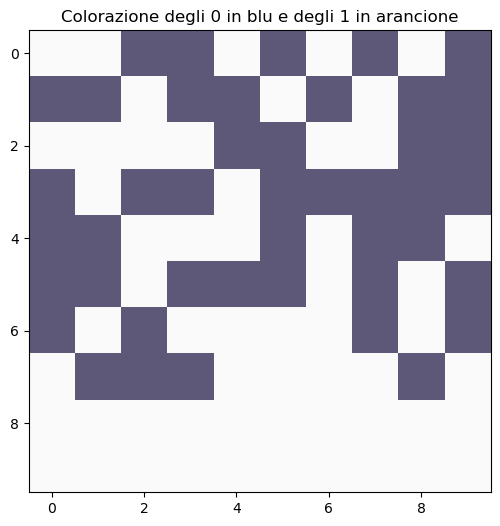

Etichette dei cluster: [0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


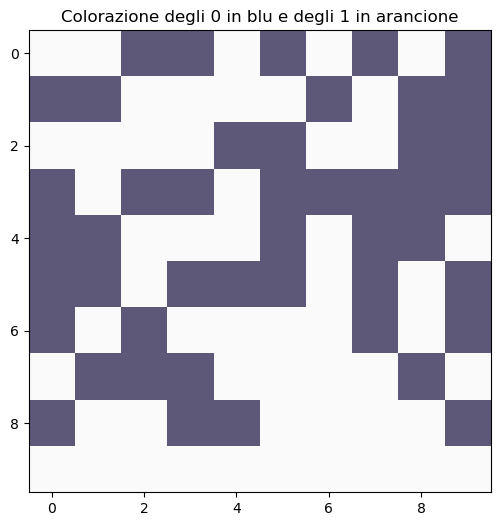

Etichette dei cluster: [0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


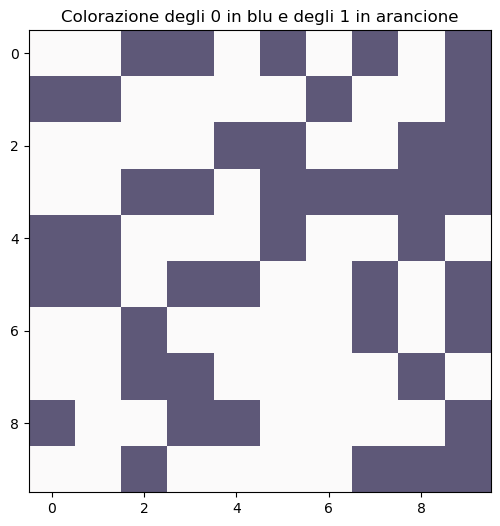

Etichette dei cluster: [0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1
 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1]


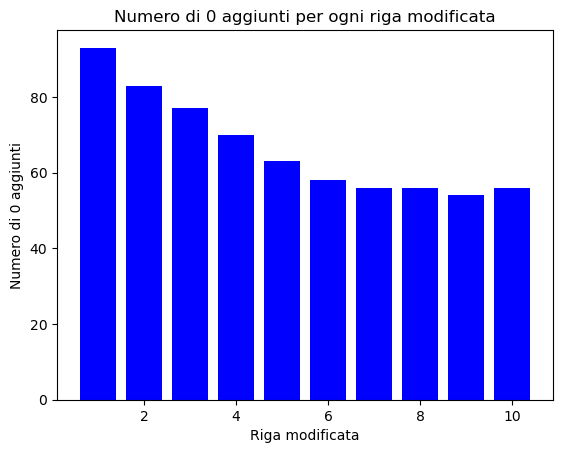

56


In [5]:
import random
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

matrice_zero = [[0] * 10 for _ in range(10)]
matrice_uno = [[1] * 10 for _ in range(10)]
num_0_per_riga = []  # Modifica per contare gli 0
num_0_aggiunti = 0  # Modifica per contare gli 0

# Add random numbers to cells containing 0 in the zero_array
for riga in matrice_zero:
    for indice, elemento in enumerate(riga):
        if elemento == 0:
            riga[indice] = random.random()
    # Transform the zero_matrix into a numpy array and then into a vector
    vector = np.array(matrice_zero).flatten()

    # Apply the K-Means algorithm with k=2
    kmeans = KMeans(n_clusters=2, n_init=2, random_state=10)
    kmeans.fit(vector.reshape(-1, 1))  # Reshape per adattare i dati alla forma richiesta da scikit-learn

    # Get cluster labels
    labels = kmeans.labels_

    # Plotting
    plt.figure(figsize=(8, 6))
    # Plot 0s in reds
    plt.imshow(np.array(labels).reshape(10, 10), cmap='Reds', interpolation='nearest', alpha=0.5)
    # Plot 1s in blues
    plt.imshow(np.array(labels).reshape(10, 10), cmap='Blues', interpolation='nearest', alpha=0.5)
    plt.title('Colorazione degli 0 in blu e degli 1 in arancione')
    plt.show()

    # Reverse the labels because we want to count the 0s
    labels_inverted = [1 if label == 0 else 0 for label in labels]
    
    num_0_aggiunti = sum(labels_inverted)  # Conta gli 0
    num_0_per_riga.append(num_0_aggiunti)  # Aggiungi il numero di 0 trovati alla lista

    print("Etichette dei cluster:", labels)
    
# Histogram plot
plt.bar(range(1, len(num_0_per_riga) + 1), num_0_per_riga, color='blue')
plt.title('Numero di 0 aggiunti per ogni riga modificata')
plt.xlabel('Riga modificata')
plt.ylabel('Numero di 0 aggiunti')
plt.show()

print(num_0_aggiunti)


Etichette dei cluster: [1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Etichette dei cluster: [1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Etichette dei cluster: [1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Etichette dei cluster: [1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Etichette dei cluster: [1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 

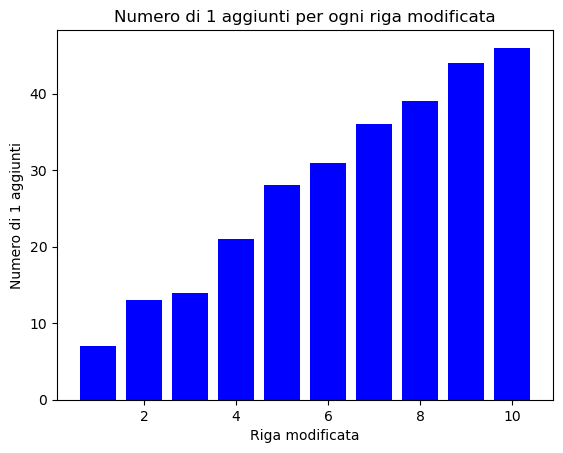

46


In [2]:
import random
import random
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

matrice_zero = [[0] * 10 for _ in range(10)]
matrice_uno = [[1] * 10 for _ in range(10)]
num_1_per_riga = []
num_1_aggiunti = 0

# Add random numbers to cells containing 0 in the zero_array
for riga in matrice_zero:
    for indice, elemento in enumerate(riga):
        if elemento == 0:
            riga[indice] = random.random()
    # Transform the zero_matrix into a numpy array and then into a vector
    vector = np.array(matrice_zero).flatten()

    # Apply the K-Means algorithm with k=2
    kmeans = KMeans(n_clusters=2, n_init=2, random_state=10)
    kmeans.fit(vector.reshape(-1, 1))  # Reshape per adattare i dati alla forma richiesta da scikit-learn

    # Get cluster labels
    labels = kmeans.labels_
    
    num_1_aggiunti = sum(labels)
    num_1_per_riga.append(num_1_aggiunti)  # Aggiungi il numero di 1 trovati alla lista

    print("Etichette dei cluster:", labels)
    
# Histogram plot
plt.bar(range(1, len(num_1_per_riga) + 1), num_1_per_riga, color='blue')
plt.title('Numero di 1 aggiunti per ogni riga modificata')
plt.xlabel('Riga modificata')
plt.ylabel('Numero di 1 aggiunti')
plt.show()

print(num_1_aggiunti)